# NEST by Example: An Introduction to the Neural Simulation Tool NEST

### Marc-Oliver Gewaltig, Abigail Morrison, Hans Ekkehard Plesser

#### This notebook adapted to NEST 3.3 was created by Hans Ekkehard Plesser
#### Revised for NEST 3.6 by Nicolai Haug and Hans Ekkehard Plesser

## Basic Terminology

* **Nodes** Nodes are all neurons, devices, and also sub-networks. Nodes have a dynamic state that changes over time and that can be influenced by incoming events. In NEST, we can distinguish roughly between three types of nodes
    * **Stimulation devices** such as `poisson_generator`, `spike_generator` or `noise_generator`.  These devices only produce output (spikes or currents) that is sent to other nodes, but do not receive any input. 
    * **Recording devices**, such as `spike_recorder`, `voltmeter` or `multimeter`. These devices collect data from other nodes and store it in memory or in files for analysis. They only receive input, but do not emit any output events to other nodes.
    * **Neurons**, such as `iaf_psc_alpha` represent our model neurons in the network. They can receive spike and current input and emit spike output.
* **Events** Events are pieces of information of a particular type. The most common event is the spike-event. Other event types are voltage events and current events.
* **Connections** Connections are communication channels between nodes. Only if one node is connected to another node, can they exchange events. Connections are weighted, directed, and specific to one event type. 
    * **Source**: The node that sending an event (spike)
    * **Target**: The node that receiving an event (spike)
    * **Weight**: How strongly will an event will influence the target node?
    * **Delay**: How long does the event take from source to target?

## NEST Desktop

- Interactive, graphical frontend for NEST
- Developed by Sebastian Spreizer, U Freiburg/FZ Jülich/U Trier
- Documentation: https://nest-desktop.readthedocs.io/en/latest/
- Run online: https://nest-desktop.apps.hbp.eu (requires HBP account)

## Notebook preparations

We first import some packages that we will need for data analysis and plotting ([NumPy](http://www.numpy.org), [Pandas](http://pandas.pydata.org), [Matplotlib](http://matplotlib.org)) and instruct the notebook to render all figures inside the notebook. We also increase the figures size, as the default figure size is rather small for most modern displays.

**NB: Switch to `EBRAINS-23.09` kernel in top left before proceeding!**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
plt.rcParams['figure.figsize'] = (10, 3)

## Firing up NEST

1. Try `import nest` first. If that works, proceed to **Getting Help**.
1. If that fails, complaining that it cannot find module `nest`, you need to extend you Python path to include the installation location of the NEST Python module on your computer.
1. The easiest way to do so is to run

        source <path to nest>/install/bin/nest_vars.sh
   
   **before** starting Python or Jupyter notebook.

In [4]:
import nest
import nest.voltage_trace
import nest.raster_plot


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.6.0
 Built: Oct 15 2023 14:47:07

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



## Getting Help

NEST provides several levels of online documentation

#### The NEST Helpdesk

NEST has [comprehensive online documentation](https://nest-simulator.readthedocs.io).

#### Help on the NEST Python interface

To obtain help on the NEST Python interface, you can either use the Python `help()` function or the IPython help mechanism by placing a `?` behind a command name, e.g.,

In [5]:
nest.Connect?

Signature:
nest.Connect(
    pre,
    post,
    conn_spec=None,
    syn_spec=None,
    return_synapsecollection=False,
)
Docstring:
Connect `pre` nodes to `post` nodes.

Nodes in `pre` and `post` are connected using the specified connectivity
(`all-to-all` by default) and synapse type (:cpp:class:`static_synapse <nest::static_synapse>` by default).
Details depend on the connectivity rule.

Lists of synapse models and connection rules are available as
``nest.synapse_models`` and ``nest.connection_rules``, respectively.

Parameters
----------
pre : NodeCollection (or array-like object)
    Presynaptic nodes, as object representing the IDs of the nodes
post : NodeCollection (or array-like object)
    Postsynaptic nodes, as object representing the IDs of the nodes
conn_spec : str or dict, optional
    Specifies connectivity rule, see below
syn_spec : str or dict, optional
    Specifies synapse model, see below
return_synapsecollection: bool
    Specifies whether or not we should return a :

## A first example

* Single leaky integrate-and-fire neuron
* Sinusoidal current injection (`ac_generator`)
* Excitatory and inhibtory spike input (`poisson_generator`) via current-based synapses
* Record voltage trace with `voltmeter`

#### Reset NEST to its original state

In [19]:
nest.ResetKernel()

#### Create the network

In [47]:
nest.ResetKernel()
nest.resolution = 0.1

neuron = nest.Create('iaf_psc_alpha')
neuron_ps = nest.Create('iaf_psc_alpha_ps')
neurons = neuron + neuron_ps 

sine = nest.Create('ac_generator',  
                   params={'amplitude': 100.0, 'frequency': 2.0})

noise = nest.Create('poisson_generator', n=2,
                    params=[{'rate': 70000.0}, {'rate': 20000.0}])

voltmeter = nest.Create('voltmeter', params={'interval': 0.1})
spike_rec = nest.Create('spike_recorder')

nest.Connect(sine, neurons)
nest.Connect(voltmeter, neurons)
nest.Connect(neurons, spike_rec)
nest.Connect(noise[:1], neurons, syn_spec={'weight': 2.0, 'delay': 1.0})
nest.Connect(noise[1:], neurons, syn_spec={'weight': -5.0, 'delay': 1.0})


Jan 15 20:24:17 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jan 15 20:24:17 NodeManager::add_node [Info]: 
    Neuron models emitting precisely timed spikes exist: the kernel property 
    off_grid_spiking has been set to true.
    
    NOTE: Mixing precise-spiking and normal neuron models may lead to inconsistent results.


In [40]:
print(neuron)
print(sine)
print(noise)
print(voltmeter)

NodeCollection(metadata=None, model=aeif_psc_alpha, size=1, first=1)
NodeCollection(metadata=None, model=ac_generator, size=1, first=2)
NodeCollection(metadata=None, model=poisson_generator, size=2, first=3, last=4)
NodeCollection(metadata=None, model=voltmeter, size=1, first=5)


#### Simulate the network

In [48]:
nest.Simulate(1000.0)


Jan 15 20:24:23 NodeManager::prepare_nodes [Info]: 
    Preparing 7 nodes for simulation.

Jan 15 20:24:23 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 7
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Number of MPI processes: 1

Jan 15 20:24:23 SimulationManager::run [Info]: 
    Simulation finished.


#### Visualize the results

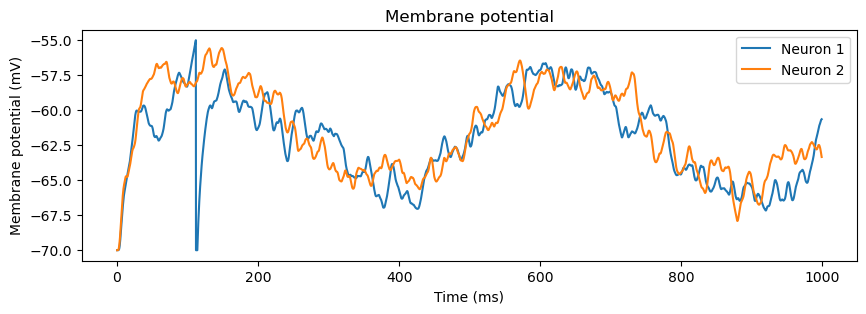

In [49]:
nest.voltage_trace.from_device(voltmeter);

In [50]:
nest.Simulate(4000)


Jan 15 20:25:43 NodeManager::prepare_nodes [Info]: 
    Preparing 7 nodes for simulation.

Jan 15 20:25:43 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 7
    Simulation time (ms): 4000
    Number of OpenMP threads: 1
    Number of MPI processes: 1

Jan 15 20:25:43 SimulationManager::run [Info]: 
    Simulation finished.


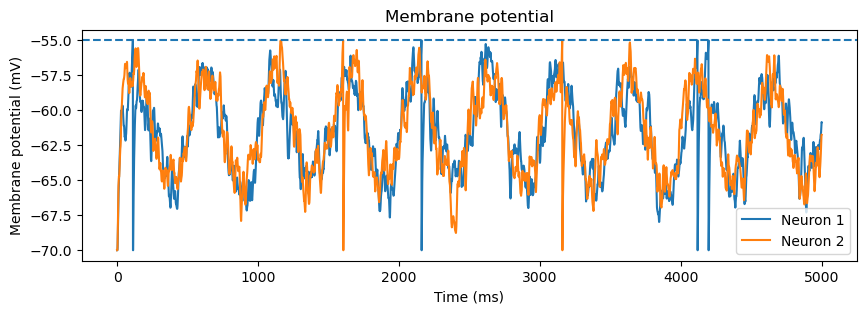

In [51]:
nest.voltage_trace.from_device(voltmeter);
plt.axhline(-55, ls='--');

In [52]:
spike_rec.events

{'senders': array([1, 2, 1, 2, 1, 1]),
 'times': array([ 111.8       , 1603.60555251, 2159.4       , 3158.05731752,
        4117.7       , 4195.8       ])}

### Inspecting the connections

`GetConnections()` returns `SynapseCollection` structure containing for each connection
1. node ID of sender
1. node ID of target
1. synapse model
1. weight
1. delay

In [53]:
conns = nest.GetConnections()
print(conns)

 source   target   synapse model   weight   delay 
-------- -------- --------------- -------- -------
      1        7  static_synapse    1.000   1.000
      2        7  static_synapse    1.000   1.000
      3        1  static_synapse    1.000   1.000
      3        2  static_synapse    1.000   1.000
      4        1  static_synapse    2.000   1.000
      4        2  static_synapse    2.000   1.000
      5        1  static_synapse   -5.000   1.000
      5        2  static_synapse   -5.000   1.000
      6        1  static_synapse    1.000   1.000
      6        2  static_synapse    1.000   1.000


To find out more about the connection properties, we use `.get()` on the synape collection:

In [54]:
conns.get()

{'delay': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 'port': [0, 0, 0, 1, 0, 1, 0, 1, 0, 1],
 'receptor': [0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
 'sizeof': [32, 32, 32, 32, 32, 32, 32, 32, 32, 32],
 'source': [1, 2, 3, 3, 4, 4, 5, 5, 6, 6],
 'synapse_id': [23, 23, 23, 23, 23, 23, 23, 23, 23, 23],
 'synapse_model': ['static_synapse',
  'static_synapse',
  'static_synapse',
  'static_synapse',
  'static_synapse',
  'static_synapse',
  'static_synapse',
  'static_synapse',
  'static_synapse',
  'static_synapse'],
 'target': [7, 7, 1, 2, 1, 2, 1, 2, 1, 2],
 'target_thread': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'weight': [1.0, 1.0, 1.0, 1.0, 2.0, 2.0, -5.0, -5.0, 1.0, 1.0]}

### Using Pandas with NEST

- Pandas is a powerful tool for managing and analysing large amounts of data
- Data returned by NEST can in many cases be easily converted to Pandas dataframes
- To first approximation, Pandas dataframes work like NumPy arrays with named columns

#### Extracting connection data

- We use the same `get()` call as above
- We obtain a tuple with one dictionary per connection
- We can convert this directly into a dataframe
- If we `print` the data, we get an ASCII-pretty-printed table

In [55]:
conn_data = pd.DataFrame.from_records(conns.get())
conn_data

,delay,port,receptor,sizeof,source,synapse_id,synapse_model,target,target_thread,weight
0,1.0,0,0,32,1,23,static_synapse,7,0,1.0
1,1.0,0,0,32,2,23,static_synapse,7,0,1.0
2,1.0,0,0,32,3,23,static_synapse,1,0,1.0
3,1.0,1,0,32,3,23,static_synapse,2,0,1.0
4,1.0,0,0,32,4,23,static_synapse,1,0,2.0
5,1.0,1,0,32,4,23,static_synapse,2,0,2.0
6,1.0,0,0,32,5,23,static_synapse,1,0,-5.0
7,1.0,1,0,32,5,23,static_synapse,2,0,-5.0
8,1.0,0,1,32,6,23,static_synapse,1,0,1.0
9,1.0,1,1,32,6,23,static_synapse,2,0,1.0


- We can even get $\LaTeX$ code

In [56]:
print(conn_data.style.to_latex())

\begin{tabular}{lrrrrrrlrrr}
 & delay & port & receptor & sizeof & source & synapse_id & synapse_model & target & target_thread & weight \\
0 & 1.000000 & 0 & 0 & 32 & 1 & 23 & static_synapse & 7 & 0 & 1.000000 \\
1 & 1.000000 & 0 & 0 & 32 & 2 & 23 & static_synapse & 7 & 0 & 1.000000 \\
2 & 1.000000 & 0 & 0 & 32 & 3 & 23 & static_synapse & 1 & 0 & 1.000000 \\
3 & 1.000000 & 1 & 0 & 32 & 3 & 23 & static_synapse & 2 & 0 & 1.000000 \\
4 & 1.000000 & 0 & 0 & 32 & 4 & 23 & static_synapse & 1 & 0 & 2.000000 \\
5 & 1.000000 & 1 & 0 & 32 & 4 & 23 & static_synapse & 2 & 0 & 2.000000 \\
6 & 1.000000 & 0 & 0 & 32 & 5 & 23 & static_synapse & 1 & 0 & -5.000000 \\
7 & 1.000000 & 1 & 0 & 32 & 5 & 23 & static_synapse & 2 & 0 & -5.000000 \\
8 & 1.000000 & 0 & 1 & 32 & 6 & 23 & static_synapse & 1 & 0 & 1.000000 \\
9 & 1.000000 & 1 & 1 & 32 & 6 & 23 & static_synapse & 2 & 0 & 1.000000 \\
\end{tabular}



- By default, we get all properties of the connections
- We can also explicitly select only certain properties

In [57]:
properties = ('source', 'target', 'delay', 'weight')
conn_data = pd.DataFrame.from_records(conns.get(properties))
conn_data

,delay,source,target,weight
0,1.0,1,7,1.0
1,1.0,2,7,1.0
2,1.0,3,1,1.0
3,1.0,3,2,1.0
4,1.0,4,1,2.0
5,1.0,4,2,2.0
6,1.0,5,1,-5.0
7,1.0,5,2,-5.0
8,1.0,6,1,1.0
9,1.0,6,2,1.0


#### Plotting "manually"

- We can also extract data from recording devices into dataframes
- Recorded data is in the `events` property of the voltmeter

In [58]:
voltmeter.get()

{'element_type': 'recorder',
 'events': {'senders': array([1, 1, 1, ..., 2, 2, 2]),
  'times': array([1.0000e-01, 2.0000e-01, 3.0000e-01, ..., 4.9988e+03, 4.9989e+03,
         4.9990e+03]),
  'V_m': array([-70.        , -70.        , -70.        , ..., -61.76314935,
         -61.76025433, -61.75669356])},
 'frozen': False,
 'global_id': 6,
 'interval': 0.1,
 'label': '',
 'local': True,
 'model': 'voltmeter',
 'model_id': 88,
 'n_events': 99980,
 'node_uses_wfr': False,
 'offset': 0.0,
 'origin': 0.0,
 'record_from': ('V_m',),
 'record_to': 'memory',
 'start': 0.0,
 'stop': 1.7976931348623157e+308,
 'thread': 0,
 'thread_local_id': 5,
 'time_in_steps': False,
 'vp': 0}

In [59]:
vm_data = pd.DataFrame(voltmeter.get('events'))

vm_data[:5]

,senders,times,V_m
0,1,0.1,-70.0
1,1,0.2,-70.0
2,1,0.3,-70.0
3,1,0.4,-70.0
4,1,0.5,-70.0


- We can plot using the `plot()` method of the Pandas DataFrame object ([more on plotting in Pandas](https://pandas.pydata.org/pandas-docs/stable/user_guide/visualization.html))

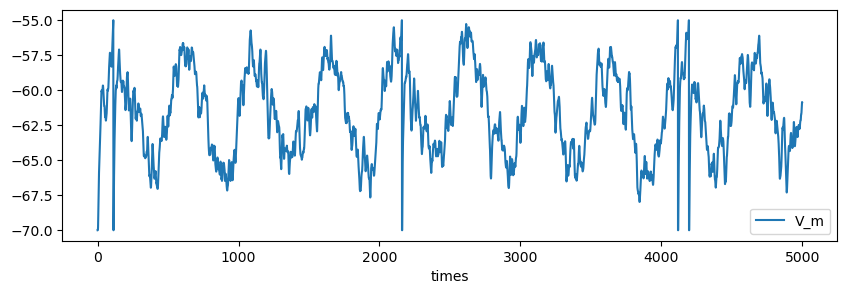

In [63]:
vm_data[vm_data.senders==1].plot(x='times', y='V_m');

- We can plot using the normal `plot()` command

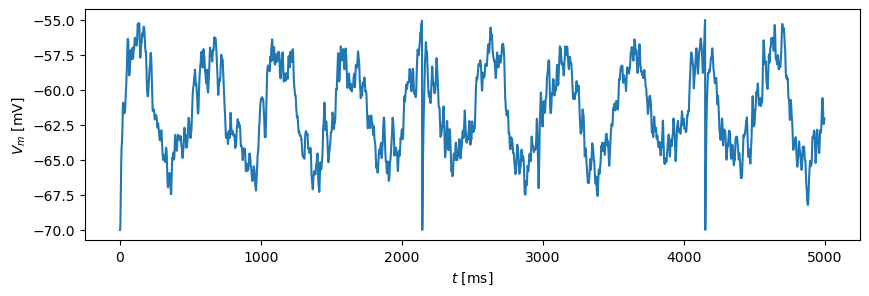

In [23]:
plt.plot(vm_data.times, vm_data.V_m)
plt.xlabel('$t$ [ms]')
plt.ylabel('$V_m$ [mV]');

## The Brunel Network: A sparsely connected network

* $N_E=10000$ excitatory neurons
* $N_I=2500$ inhibitory neurons
* 10% connectivity
* Scaling parameter allows adjustment of network size for faster testing (changes dynamics)
* N. Brunel, J Comput Neurosci 8:183 (2000)

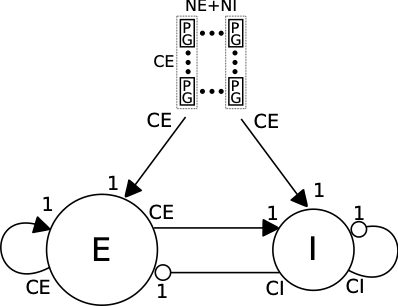

### Define parameters

In [64]:
# Network parameters. These are given in Brunel (2000) J.Comp.Neuro.
g       = 5.0    # Ratio of IPSP to EPSP amplitude: J_I/J_E
eta     = 2.0    # rate of external population in multiples of threshold rate
delay   = 1.5    # synaptic delay in ms
tau_m   = 20.0   # Membrane time constant in ms
V_th    = 20.0   # Spike threshold in mV

scale = 1
N_E = int(scale * 10000)
N_I = int(scale *  2500)
N_neurons = N_E + N_I

C_E = int(N_E / 10) # number of excitatory synapses per neuron
C_I = int(N_I / 10) # number of inhibitory synapses per neuron

J_E  = 0.1
J_I  = -g * J_E

nu_ex  = eta * V_th / (J_E * C_E * tau_m)  # rate of an external neuron in ms^-1
p_rate = 1000.0 * nu_ex * C_E              # rate of the external population in s^-1

### Configure kernel and neuron defaults

In [88]:
nest.ResetKernel()
nest.total_num_virtual_procs = 4
nest.rng_seed = 15012024

In [89]:
brunel_neuron_params = {"C_m": 1.0,
                        "tau_m": tau_m,
                        "t_ref": 2.0,
                        "E_L": 0.0,
                        "V_th": V_th,
                        "V_reset": 10.0}
nest.SetDefaults("iaf_psc_delta", brunel_neuron_params)

### Create neurons

In [90]:
nodes_E = nest.Create("iaf_psc_delta", N_E)
nodes_I = nest.Create("iaf_psc_delta", N_I)
nodes = nodes_E + nodes_I

In [91]:
print(nodes_E)

NodeCollection(metadata=None, model=iaf_psc_delta, size=10000, first=1, last=10000)


In [92]:
print(nodes_I)

NodeCollection(metadata=None, model=iaf_psc_delta, size=2500, first=10001, last=12500)


In [93]:
print(nodes)

NodeCollection(metadata=None, model=iaf_psc_delta, size=12500, first=1, last=12500)


### Connect neurons with each other

In [94]:
excitatory = {"synapse_model": "static_synapse", "weight": J_E, "delay": delay}
inhibitory = {"synapse_model": "static_synapse", "weight": J_I, "delay": delay}

nest.Connect(nodes_E, 
             nodes,
             conn_spec={"rule": "fixed_indegree", "indegree": C_E},
             syn_spec=excitatory)

nest.Connect(nodes_I, nodes,
             conn_spec={"rule": "fixed_indegree", "indegree": C_I},
             syn_spec=inhibitory)

### Add stimulation and recording devices

In [95]:
noise = nest.Create("poisson_generator", params={"rate": p_rate})

# connect using all_to_all: one noise generator to all neurons
nest.Connect(noise, nodes, syn_spec=excitatory)

spikes_E = nest.Create("spike_recorder", params={"label": "Exc"})
spikes_I = nest.Create("spike_recorder", params={"label": "Inh"})

N_rec = 100   # Number of neurons to record from

# connect using all_to_all: all recorded excitatory neurons to one detector
nest.Connect(nodes_E[:N_rec], spikes_E)
nest.Connect(nodes_I[:N_rec], spikes_I)

In [96]:
nest.GetKernelStatus()

{'adaptive_target_buffers': True,
 'biological_time': 0.0,
 'buffer_size_spike_data': 2,
 'buffer_size_target_data': 2,
 'connection_rules': ('one_to_one',
  'all_to_all',
  'fixed_indegree',
  'fixed_outdegree',
  'pairwise_bernoulli',
  'symmetric_pairwise_bernoulli',
  'fixed_total_number'),
 'data_path': '',
 'data_prefix': '',
 'dict_miss_is_error': True,
 'growth_curves': ('gaussian', 'linear', 'sigmoid'),
 'growth_factor_buffer_spike_data': 1.5,
 'growth_factor_buffer_target_data': 1.5,
 'keep_source_table': True,
 'local_num_threads': 4,
 'local_spike_counter': 0,
 'max_buffer_size_target_data': 16777216,
 'max_delay': 1.5,
 'max_num_syn_models': 512,
 'max_update_time': -inf,
 'min_delay': 1.0,
 'min_update_time': inf,
 'ms_per_tic': 0.001,
 'network_size': 12503,
 'node_models': ('volume_transmitter',
  'weight_recorder',
  'ac_generator',
  'dc_generator',
  'gamma_sup_generator',
  'mip_generator',
  'noise_generator',
  'inhomogeneous_poisson_generator',
  'poisson_generat

### Simulate

The simulation progress is shown in the terminal window in which you started `ipython notebook`.

In [97]:
simtime = 1000
nest.Simulate(simtime)


Jan 15 20:50:36 NodeManager::prepare_nodes [Info]: 
    Preparing 12512 nodes for simulation.

Jan 15 20:50:37 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 12512
    Simulation time (ms): 1000
    Number of OpenMP threads: 4
    Number of MPI processes: 1

Jan 15 20:50:43 SimulationManager::run [Info]: 
    Simulation finished.


### Extract recorded data and display

#### Computing spike rates

In [98]:
rate_ex= spikes_E.n_events / simtime * 1000 / N_rec
print(f"Excitatory rate: {rate_ex:.2f} [1/s]")

rate_in= spikes_I.n_events / simtime * 1000 / N_rec
print(f"Inhibitory rate: {rate_in:.2f} [1/s]")

Excitatory rate: 36.40 [1/s]
Inhibitory rate: 36.09 [1/s]


#### Visualization with raster_plot

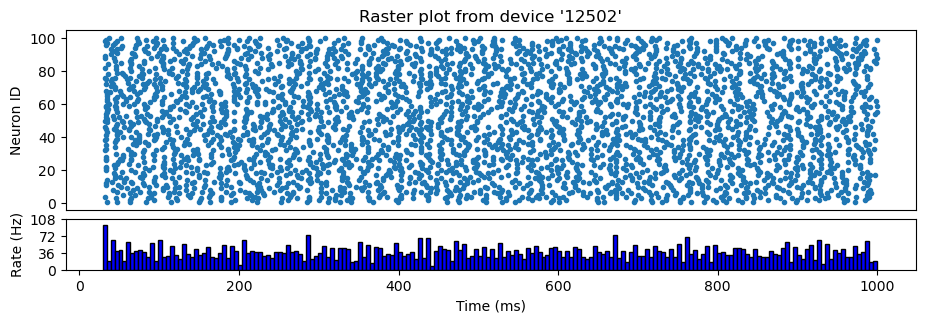

In [99]:
nest.raster_plot.from_device(spikes_E, hist=True);

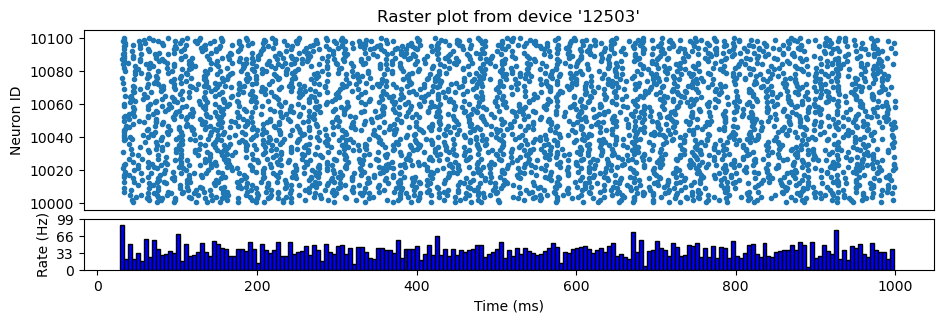

In [100]:
nest.raster_plot.from_device(spikes_I, hist=True);

## Parallelism in NEST

- NEST can combine MPI-based and thread-based parallelism
- The key concept in parallel NEST is the *virtual process* (VP)
    - For $N_M$ MPI processes with $N_T$ threads each, be have $$N_{VP}=N_M\times N_T$$ virtual processes
    - For fixed $N_{VP}$, a NEST simulation shall yield identical results, independent of how the virtual processes are divided into MPI processes and threads
    - Recording devices write one file per MPI process, data from those files have to be pooled
- In this notebook, we only use thread-based parallelism: $N_{VP}=N_T$, $N_M=1$

## Random numbers in NEST

NEST 3 manages random numbers internally for serial and parallel simulations.  You can easily change the random number generator used and set the random seed:

In [36]:
nest.rng_types

('Philox_32',
 'Philox_64',
 'Threefry_32',
 'Threefry_64',
 'mt19937',
 'mt19937_64')

In [101]:
nest.set(rng_type='Threefry_32', rng_seed=1234567)

In [102]:
nest.rng_type = 'Threefry_32'
nest.rng_seed = 26

### Creating neurons with randomized membrane potential

- We want to randomize the initial $V_m$ uniformly over $[V_{\textrm{min}}, V_{\textrm{max}})$ 
- First, we set the random number generator type and seed and the number of virtual processes
- We also set model defaults for our neuron model

In [103]:
nest.ResetKernel()
nest.set(rng_type='Threefry_32', 
         rng_seed=1234567,
         total_num_virtual_procs=4)
nest.SetDefaults("iaf_psc_delta", brunel_neuron_params)

- We now create the neurons, specificying the desired $V_m$ distribution

In [104]:
nodes_E = nest.Create("iaf_psc_delta", N_E, params={'V_m': nest.random.uniform(-V_th, V_th)})
nodes_I = nest.Create("iaf_psc_delta", N_I, params={'V_m': nest.random.uniform(-V_th, V_th)})
nodes = nodes_E + nodes_I

#### Connecting with randomized weights

- We exploit that `Connect()` can draw random weights
- We only randomize outgoing connections from the excitatory neurons

In [105]:
mean_J_E = J_E
std_J_E = 0.5 * J_E
mean_lgnrm = np.log(mean_J_E**2 / np.sqrt(mean_J_E**2 + std_J_E**2))
std_lgnrm = np.sqrt(np.log(1 + std_J_E**2 / mean_J_E**2))
                    
excitatory_random = {"synapse_model": "static_synapse", "delay": delay,
                     "weight": nest.random.lognormal(mean=mean_lgnrm, std=std_lgnrm)}

nest.Connect(nodes_E, nodes,
             conn_spec={"rule": "fixed_indegree", "indegree": C_E},
             syn_spec=excitatory_random)

nest.Connect(nodes_I, nodes,
             conn_spec={"rule": "fixed_indegree", "indegree": C_I},
             syn_spec=inhibitory)

#### Adding stimulation and recording devices

- Same as before

In [106]:
noise = nest.Create("poisson_generator", params={"rate": p_rate})

# connect using all_to_all: one noise generator to all neurons
nest.Connect(noise, nodes, syn_spec=excitatory)

spikes_E = nest.Create("spike_recorder", params={"label": "Exc"})
spikes_I = nest.Create("spike_recorder", params={"label": "Inh"})

N_rec   = 100   # Number of neurons to record from

# connect using all_to_all: all recorded excitatory neurons to one detector
nest.Connect(nodes_E[:N_rec], spikes_E)
nest.Connect(nodes_I[:N_rec], spikes_I)

### Inspecting the Network

#### Initial membrane potentials

- Read out $V_m$ from all neurons
- Plot as scatter plot and histogram

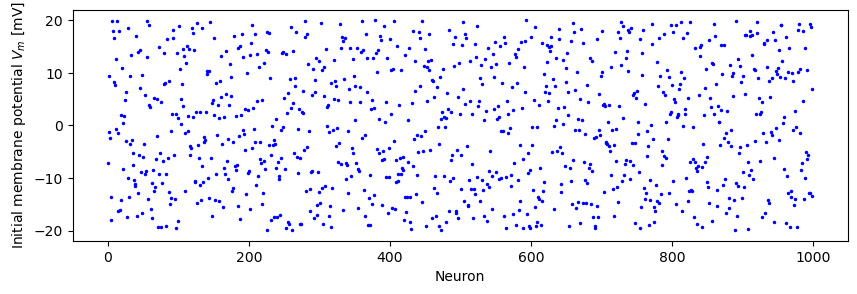

In [107]:
plt.plot(nodes[:1000].V_m, 'b.', markersize=3)
plt.xlabel('Neuron')
plt.ylabel('Initial membrane potential $V_m$ [mV]');

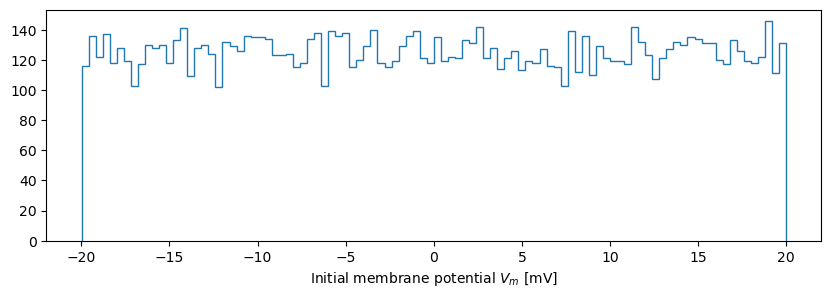

In [108]:
plt.hist(nodes.V_m, bins=100, histtype='step')
plt.xlabel('Initial membrane potential $V_m$ [mV]');

#### Synaptic weights

- We collect data on all outgoing synapses from the first 100 neurons
- We need to specify `target=nodes` to avoid "picking up" connections to the spike recorder
- We store as Pandas data frame

In [109]:
exc_conns = nest.GetConnections(source=nodes_E[:100], target=nodes)
exc_weights = pd.DataFrame({'weight': exc_conns.get('weight')})

exc_weights.describe().T

,count,mean,std,min,25%,50%,75%,max
weight,124509.0,0.100066,0.049631,0.01104,0.065239,0.089801,0.123153,0.699562


- We scatter plot the first 1000 weights
- We create a histogram of all

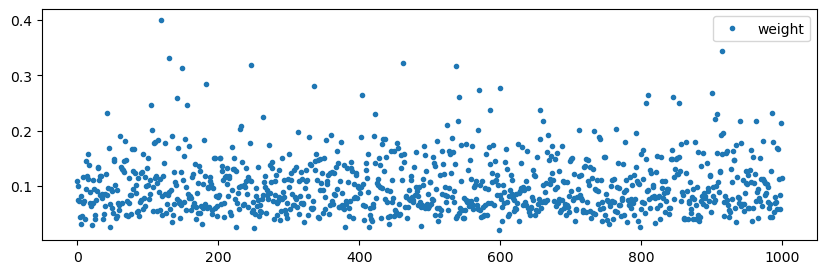

In [110]:
exc_weights[:1000].plot(style='.');

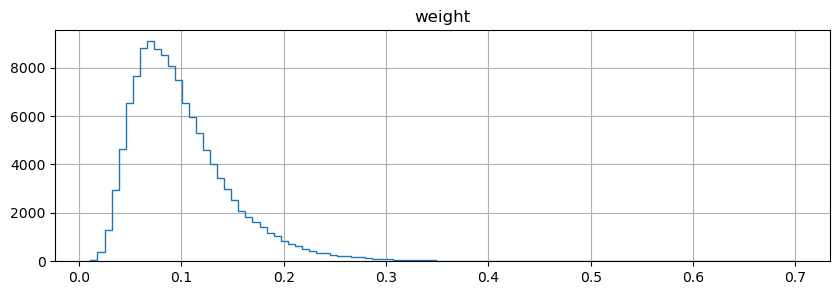

In [111]:
exc_weights.hist(bins=100, histtype='step');

### Simulating the network

In [112]:
nest.Simulate(1000)


Jan 15 21:01:31 NodeManager::prepare_nodes [Info]: 
    Preparing 12512 nodes for simulation.

Jan 15 21:01:31 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 12512
    Simulation time (ms): 1000
    Number of OpenMP threads: 4
    Number of MPI processes: 1

Jan 15 21:01:39 SimulationManager::run [Info]: 
    Simulation finished.


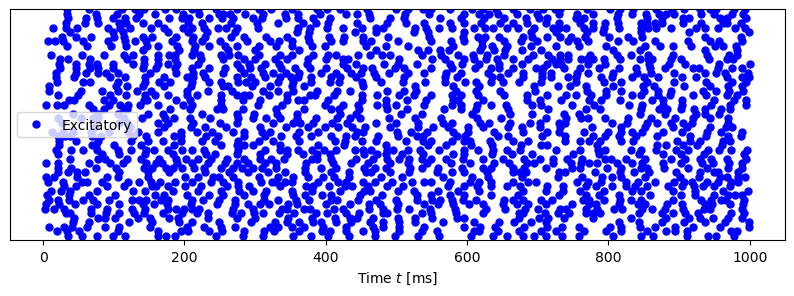

In [113]:
sdE_data = pd.DataFrame(spikes_E.get('events'))
sdI_data = pd.DataFrame(spikes_I.get('events'))

e_spikes_plot = sdE_data[sdE_data.senders <= 100]
plt.plot(e_spikes_plot.times, e_spikes_plot.senders, 'bo', 
         markersize=5, label='Excitatory')
plt.legend()
plt.xlabel('Time $t$ [ms]')
plt.yticks([])
plt.ylim(0, 51);

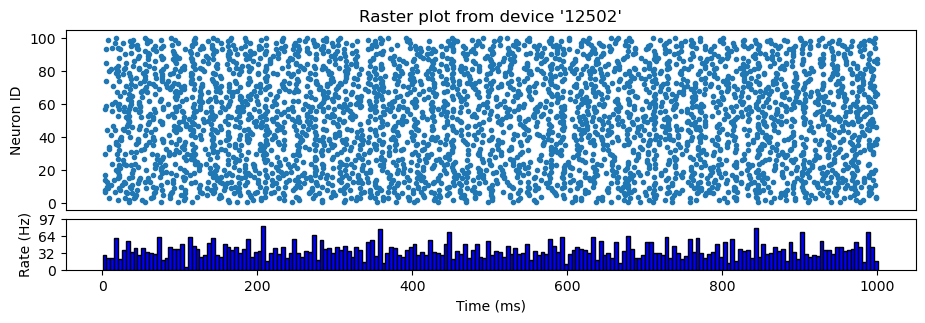

In [114]:
nest.raster_plot.from_device(spikes_E, hist=True)

In [115]:
nest.num_connections

15637700